In [1]:
# Checklist:
# AWS emr-5.29.0
# MASTER r5d.8xlarge 1x, no EBS
# CORE r5d.8xlarge 4x, no EBS
# Custom bootstrap action: s3://ydatazian/bootstrap.sh
# Allow ssh in master node security group

In [1]:
import tqdm.notebook as tqdm
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('max_colwidth', 120 * 10)
pd.set_option('display.width', 120)

# SparkSession

https://spark.apache.org/docs/2.4.4/api/python/pyspark.html

https://spark.apache.org/docs/2.4.4/api/python/pyspark.sql.html

In [2]:
import findspark
findspark.init()

import spark_utils
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext("yarn", "My App", conf=spark_utils.get_spark_conf())
se = SparkSession(sc)
spark_utils.print_ui_links()

NameNode: http://ec2-34-206-52-29.compute-1.amazonaws.com:50070
YARN: http://ec2-34-206-52-29.compute-1.amazonaws.com:8088
Spark UI: http://ec2-34-206-52-29.compute-1.amazonaws.com:20888/proxy/application_1590528820339_0001


# Register all tables for sql queries

In [3]:
from IPython.display import display
tables = ["clicks_test", "clicks_train", 
          "documents_categories", "documents_entities", "documents_meta", "documents_topics", 
          "events", "page_views", "page_views_sample", "promoted_content"]
for name in tqdm.tqdm(tables):
    df = se.read.parquet("s3://ydatazian/{}.parquet".format(name))
    df.registerTempTable(name)
    print(name)
    display(df.limit(3).toPandas())

clicks_test


,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754


clicks_train


,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1


documents_categories


,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92


documents_entities


,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865314504701
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399113728441297
2,1524246,839907a972930b17b125eb0247898412,0.392095749652966


documents_meta


,document_id,source_id,publisher_id,publish_time
0,1595802,1,603,2016-06-05 00:00:00
1,1524246,1,603,2016-05-26 11:00:00
2,1617787,1,603,2016-05-27 00:00:00


documents_topics


,document_id,topic_id,confidence_level
0,1595802,140,0.0731131601068925
1,1595802,16,0.0594164867373976
2,1595802,143,0.0454207537554526


events


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505


page_views


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


page_views_sample


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


promoted_content


,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7


# All clicks

In [5]:
%%time
! hdfs dfs -rm -r /clicks.parquet
se.sql("""
select *
from 
    (
    select 
        *,
        true as is_train
    from clicks_train
    )
    union
    (
    select 
        *,
        "0" as clicked,
        false as is_train
    from clicks_test
    )
""").write.parquet("/clicks.parquet")
se.read.parquet("/clicks.parquet").registerTempTable("clicks")

Deleted /clicks.parquet
CPU times: user 24.3 ms, sys: 5.94 ms, total: 30.2 ms
Wall time: 48.4 s


In [7]:
se.table("clicks").show(5)

+----------+------+-------+--------+
|display_id| ad_id|clicked|is_train|
+----------+------+-------+--------+
|  16874662|257719|      0|   false|
|  16874684|158271|      0|   false|
|  16874738|285721|      0|   false|
|  16874795|199447|      0|   false|
|  16874839|222070|      0|   false|
+----------+------+-------+--------+
only showing top 5 rows



# Ad_id features

In [8]:
%%time
! hdfs dfs -rm -r /ad_entities.parquet
se.sql("""
select 
    pc.ad_id,
    collect_list(struct(de.entity_id, cast(de.confidence_level as float) as confidence_level)) as ad_entities
from promoted_content as pc join documents_entities as de on pc.document_id = de.document_id
group by pc.ad_id
""").write.parquet("/ad_entities.parquet")
se.read.parquet("/ad_entities.parquet").registerTempTable("ad_entities")

rm: `/ad_entities.parquet': No such file or directory
CPU times: user 21.4 ms, sys: 6.23 ms, total: 27.6 ms
Wall time: 10.9 s


In [9]:
se.table("ad_entities").limit(5).toPandas()

,ad_id,ad_entities
0,100142,"[(98bf11f29dd0160f58d870c0c7c6f07f, 0.226028174161911)]"
1,100786,"[(810e7275c37b02ca9a5f9d9d231026a5, 0.4200795590877533), (8324e76d44852e22856240b6d1aef8ed, 0.35910481214523315), (d551b0d2feb1f8a89239bccddd1165d8, 0.3047851026058197), (b3a036f452490cf3f66b3e9dd26e45c8, 0.2971663773059845), (1834eb4deaf946bebcd2f6a3e21e7261, 0.28737881779670715), (10fc9950c0115ec50bda13e11c97371b, 0.23719897866249084)]"
2,100927,"[(131f700eabaa8f979501bfab7e1292e9, 0.5807134509086609), (b7da2a65e94bb207d22d2f0a4160be8f, 0.487897664308548), (ef598e7005c5ce1415fe6d8c7b40b6fc, 0.2968069016933441), (16eab421b5c6234b361fbb4e165a5748, 0.2683892548084259), (88c79cc2ad4990c2157c9e87193ad9fd, 0.2671460807323456)]"
3,100956,"[(328584ed6b068951678fa66d0d555aa1, 0.4431387782096863)]"
4,101136,"[(a76d913c10865c3b5c2b2fbc194af0bc, 0.8150035738945007)]"


In [10]:
se.table("ad_entities").printSchema()

root
 |-- ad_id: string (nullable = true)
 |-- ad_entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- entity_id: string (nullable = true)
 |    |    |-- confidence_level: float (nullable = true)



In [11]:
%%time
! hdfs dfs -rm -r /ad_topics.parquet
se.sql("""
select 
    pc.ad_id,
    collect_list(struct(dt.topic_id, cast(dt.confidence_level as float) as confidence_level)) as ad_topics
from promoted_content as pc join documents_topics as dt on pc.document_id = dt.document_id
group by pc.ad_id
""").write.parquet("/ad_topics.parquet")
se.read.parquet("/ad_topics.parquet").registerTempTable("ad_topics")

rm: `/ad_topics.parquet': No such file or directory
CPU times: user 17.8 ms, sys: 7.84 ms, total: 25.7 ms
Wall time: 9.61 s


In [12]:
se.table("ad_topics").limit(5).toPandas()

,ad_id,ad_topics
0,100142,"[(181, 0.3299613893032074)]"
1,100786,"[(249, 0.1530769318342209), (32, 0.08436058461666107), (297, 0.0451713502407074), (192, 0.03516631945967674), (85, 0.01974184438586235), (10, 0.01973884180188179), (181, 0.018032323569059372), (65, 0.012276466004550457), (146, 0.011644311249256134), (219, 0.0092721376568079)]"
2,100841,"[(92, 0.038239285349845886), (8, 0.029061492532491684), (100, 0.0285784974694252), (174, 0.019483203068375587), (258, 0.015252185054123402)]"
3,100927,"[(269, 0.34830808639526367)]"
4,100956,"[(16, 0.07634807378053665), (85, 0.0463380366563797), (249, 0.030323520302772522), (92, 0.018669400364160538), (17, 0.014306258410215378), (154, 0.010022616013884544), (258, 0.008142800070345402)]"


In [13]:
se.table("ad_topics").printSchema()

root
 |-- ad_id: string (nullable = true)
 |-- ad_topics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- topic_id: string (nullable = true)
 |    |    |-- confidence_level: float (nullable = true)



# Display_id features (based on page_views)

In [14]:
# 3% of users have display events with clicks (organic click rate)
print(se.sql("select distinct(uuid) from page_views").count())
print(se.sql("select distinct(uuid) from events").count())

717506889
19794967


In [15]:
# display_ids are unique
print(se.table('events').count())
print(se.sql('select distinct(display_id) from events').count())

23120126
23120126


In [16]:
# all display_ids are split 73% train / 27% test
print(se.sql('select distinct(display_id) from clicks_train').count())
print(se.sql('select distinct(display_id) from clicks_test').count())

16874593
6245533


1.0
92.0
CPU times: user 82.4 ms, sys: 0 ns, total: 82.4 ms
Wall time: 46.1 s


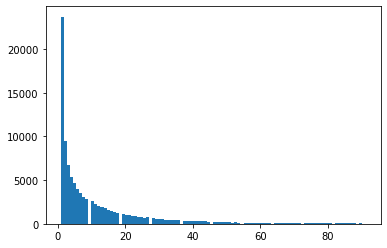

In [17]:
%%time
# page views per user
sizes = se.sql("""
select 
    uuid,
    count(1) as s
from page_views
group by uuid
limit 100000
""").rdd.map(lambda x: x.s).collect()
sizes = np.array(sizes)
print(np.percentile(sizes, 1))
print(np.percentile(sizes, 99))
sizes = sizes[sizes < np.percentile(sizes, 99)]
_ = plt.hist(sizes, bins=100)

In [18]:
%%time
! hdfs dfs -rm -r /display_topics.parquet
se.sql("""
select 
    tmp.display_id,
    collect_list(struct(tmp.topic_id, tmp.confidence_level)) as display_topics
from
    (
    select 
        e.display_id,
        dt.topic_id,
        sum(cast(dt.confidence_level as float)) as confidence_level
    from events as e 
        join page_views as pv on e.uuid = pv.uuid
        join documents_topics as dt on pv.document_id = dt.document_id
    group by e.display_id, dt.topic_id
    ) as tmp
group by tmp.display_id
""").write.parquet("/display_topics.parquet")
se.read.parquet("/display_topics.parquet").registerTempTable("display_topics")

rm: `/display_topics.parquet': No such file or directory
CPU times: user 18.2 ms, sys: 17.7 ms, total: 35.9 ms
Wall time: 2min 16s


In [19]:
se.table('display_topics').limit(5).toPandas()

,display_id,display_topics
0,10000108,"[(285, 0.05787719041109085), (36, 0.011638008058071136), (23, 0.011111683212220669), (226, 0.01831120066344738), (24, 0.03409966453909874)]"
1,10000172,"[(250, 0.026951756328344345), (271, 0.00905686430633068), (165, 0.011910940520465374), (291, 0.011835604906082153), (252, 0.04121653363108635), (8, 0.06744621694087982), (296, 0.0131217110902071), (117, 0.009993643499910831), (140, 0.09547334164381027), (43, 0.07451725751161575), (216, 0.030948465690016747), (265, 0.017551081255078316), (65, 0.01133553497493267)]"
2,10000304,"[(239, 0.009890459477901459), (148, 0.03774159401655197), (250, 0.01871490851044655), (19, 0.010221339762210846), (25, 0.09550920873880386), (9, 0.00835688691586256), (286, 0.011767380870878696), (43, 0.035802148282527924), (281, 0.0649278499186039), (134, 0.008266095072031021), (233, 0.010877534747123718), (17, 0.00829986296594143), (160, 0.6086612334474921), (254, 0.08038891851902008), (179, 0.04806268401443958), (86, 0.028774918988347054), (234, 0.010964683257043362), (181, 0.035898368805646896), (156, 0.008396882563829422), (110, 0.008071144111454487), (87, 0.03606506623327732), (8, 0.3981176484376192), (284, 0.013923902995884418), (265, 0.0391863826662302), (82, 0.035799325443804264), (136, 0.05665453150868416), (168, 0.008507328107953072), (89, 0.029356347396969795), (276, 0.009034703485667706), (16, 0.06784232892096043), (163, 0.03452271595597267), (10, 0.16390062309801579), (192, 0.04684021882712841), (92, 0.030851103365421295), (215, 0.00808124803006649), (47, 0.035426488146185875), (242, 0.010148745961487293), (173, 0.28092633187770844), (53, 0.010009721852838993), (213, 0.008168152533471584), (216, 0.008100329898297787), (219, 0.008387570269405842), (217, 0.040475181..."
3,10000454,"[(214, 0.11549584567546844), (66, 0.10618241131305695)]"
4,10000472,"[(16, 0.04280128329992294), (214, 0.24369288980960846), (174, 0.09856970608234406), (240, 0.5298454761505127), (66, 0.3372142016887665), (8, 0.07532715797424316), (252, 0.5444167256355286), (93, 0.023324333131313324), (153, 0.10199250280857086), (211, 0.03875367343425751), (288, 0.22514894604682922), (170, 0.06858696043491364), (19, 0.020135674625635147), (12, 0.008581609465181828), (176, 0.020381975919008255), (131, 0.0251818485558033), (294, 0.10637307912111282), (107, 0.028440061956644058), (43, 0.046946462243795395), (216, 0.03410104662179947), (172, 0.00802045688033104), (162, 0.009045521728694439)]"


In [20]:
%%time
! hdfs dfs -rm -r /display_views.parquet
se.sql("""
select 
    e.display_id,
    collect_list(pv.document_id) as views
from events as e 
    join page_views as pv on e.uuid = pv.uuid
group by e.display_id
""").write.parquet("/display_views.parquet")
se.read.parquet("/display_views.parquet").registerTempTable("display_views")

rm: `/display_views.parquet': No such file or directory
CPU times: user 23.2 ms, sys: 6.56 ms, total: 29.8 ms
Wall time: 1min 13s


In [21]:
se.table('display_views').limit(5).toPandas()

,display_id,views
0,10000108,[1126487]
1,10000172,[1233989]
2,10000304,"[1075288, 1075290, 230213, 1088232, 1077407, 1077398, 1077376, 1077622, 1086036, 1077294, 1077663, 1077542, 229897, 654481]"
3,10000454,"[2410517, 2353341]"
4,10000472,"[2206674, 1096452, 1179111, 2398538, 1479883, 2851366, 1429540, 2350764, 2791394, 1179111]"


In [22]:
! hdfs dfs -du -s -h "/*"

39.8 M  /ad_entities.parquet
13.9 M  /ad_topics.parquet
888.8 M  /clicks.parquet
3.7 G  /display_topics.parquet
1.8 G  /display_views.parquet
0  /tmp
220.5 M  /user
312  /var


# Prepare dataset for VW

We will predict a *click* based on:
- ad_id
- document_id
- campaign_id
- advertiser_id
- ad_topics
- ad_entities
- display_topics
- display_views

In [23]:
se.table("clicks").show(3)

+----------+------+-------+--------+
|display_id| ad_id|clicked|is_train|
+----------+------+-------+--------+
|  16874662|257719|      0|   false|
|  16874684|158271|      0|   false|
|  16874738|285721|      0|   false|
+----------+------+-------+--------+
only showing top 3 rows



In [24]:
%%time
# join everything
! hdfs dfs -rm -r /features.parquet
se.sql("""
select 
    c.*,
    pc.document_id,
    pc.campaign_id,
    pc.advertiser_id,
    at.ad_topics,
    ae.ad_entities,
    dt.display_topics,
    dv.views
from clicks as c 
    left join promoted_content as pc on c.ad_id = pc.ad_id
    left join ad_topics as at        on c.ad_id = at.ad_id
    left join ad_entities as ae      on c.ad_id = ae.ad_id
    left join display_topics as dt   on c.display_id = dt.display_id
    left join display_views as dv    on c.display_id = dv.display_id
""").write.parquet("/features.parquet")
se.read.parquet("/features.parquet").registerTempTable('features')

rm: `/features.parquet': No such file or directory
CPU times: user 17.4 ms, sys: 13.5 ms, total: 30.9 ms
Wall time: 1min 13s


In [25]:
se.table('features').limit(10).toPandas()

,display_id,ad_id,clicked,is_train,document_id,campaign_id,advertiser_id,ad_topics,ad_entities,display_topics,views
0,10000108,488469,0,True,2387648,65,29,"[(117, 0.01972847431898117), (291, 0.014938888140022755), (92, 0.009732389822602272)]","[(9def146bc7cf83aa42bd7d71908a914d, 0.680088460445404)]","[(285, 0.05787719041109085), (36, 0.011638008058071136), (23, 0.011111683212220669), (226, 0.01831120066344738), (24, 0.03409966453909874)]",[1126487]
1,10000108,406686,0,True,1671134,27505,2879,"[(26, 0.062456466257572174), (102, 0.055621176958084106), (291, 0.03329614922404289), (16, 0.03061726875603199), (256, 0.018938491120934486), (231, 0.012377371080219746)]","[(0e97841bde120a8faa5edeaca0b408d1, 0.3446024954319)]","[(285, 0.05787719041109085), (36, 0.011638008058071136), (23, 0.011111683212220669), (226, 0.01831120066344738), (24, 0.03409966453909874)]",[1126487]
2,10000108,132815,1,True,1227645,17018,331,"[(285, 0.2907588481903076), (292, 0.25437211990356445), (93, 0.128691628575325)]","[(6de378ea48c0f426a9337e69799d3c5c, 0.5146595239639282), (24cb4629207b6ee75d44eaba8d80ebf9, 0.38699421286582947)]","[(285, 0.05787719041109085), (36, 0.011638008058071136), (23, 0.011111683212220669), (226, 0.01831120066344738), (24, 0.03409966453909874)]",[1126487]
3,10000108,406704,0,True,1678714,27506,2879,"[(26, 0.062456440180540085), (102, 0.05562115088105202), (291, 0.03329617530107498), (16, 0.030617164447903633), (256, 0.018938491120934486), (231, 0.012377475388348103)]","[(0e97841bde120a8faa5edeaca0b408d1, 0.3446024954319)]","[(285, 0.05787719041109085), (36, 0.011638008058071136), (23, 0.011111683212220669), (226, 0.01831120066344738), (24, 0.03409966453909874)]",[1126487]
4,10000108,471551,0,True,2320075,32100,1743,"[(260, 0.21083606779575348)]",None,"[(285, 0.05787719041109085), (36, 0.011638008058071136), (23, 0.011111683212220669), (226, 0.01831120066344738), (24, 0.03409966453909874)]",[1126487]
5,10000108,133677,0,True,1297868,17143,1919,"[(138, 0.31832021474838257)]","[(e2a8b2cdfec0424811e26ec81fe32f1c, 0.41047585010528564), (3488cf58018956e868fd6094cee461a6, 0.2921636402606964)]","[(285, 0.05787719041109085), (36, 0.011638008058071136), (23, 0.011111683212220669), (226, 0.01831120066344738), (24, 0.03409966453909874)]",[1126487]
6,10000108,449087,0,True,2135836,31474,3052,"[(89, 0.3728715479373932), (271, 0.015715807676315308)]","[(cf9d52fe87a5d05f0ffeec1441dd8bd1, 0.5649054646492004), (ad72bfd8c03d8b5813aeb17867bc08ff, 0.5146899223327637), (a2750039e897552720b6eca28bc9e277, 0.2961665689945221), (d9f1823bdc43bfe6ca57f9d53fc132d7, 0.27304092049598694), (217d95aa6aae40ab13efd222d5c79e5a, 0.2568173408508301)]","[(285, 0.05787719041109085), (36, 0.011638008058071136), (23, 0.011111683212220669), (226, 0.01831120066344738), (24, 0.03409966453909874)]",[1126487]
7,10000172,116124,1,True,393819,2163,916,"[(116, 0.10449840873479843)]","[(36f211cd593772f0c744091defa7e23d, 0.7523783445358276)]","[(250, 0.026951756328344345), (271, 0.00905686430633068), (165, 0.011910940520465374), (291, 0.011835604906082153), (252, 0.04121653363108635), (8, 0.06744621694087982), (296, 0.0131217110902071), (117, 0.009993643499910831), (140, 0.09547334164381027), (43, 0.07451725751161575), (216, 0.030948465690016747), (265, 0.017551081255078316), (65, 0.01133553497493267)]",[1233989]
8,10000172,45192,0,True,953930,6296,1594,"[(136, 0.22979213297367096), (286, 0.00889626331627369)]","[(3e649c6ac725ebf28232ed95fb72383b, 0.7512244582176208), (01bfa7a8b6b7648b532e1aec9bcc0537, 0.35103821754455566), (780881eca6d43e3ba3de8fcc883102da, 0.30377885699272156)]","[(250, 0.026951756328344345), (271, 0.00905686430633068), (165, 0.011910940520465374), (291, 0.011835604906082153), (252, 0.04121653363108635), (8, 0.06744621694087982), (296, 0.0131217110902071), (117, 0.009993643499910831), (140, 0.09547334164381027), (43, 0.07451725751161575), (216, 0.030948465690016747), (265, 0.017551081255078316), (65, 0.01133553497493267)]",[1233989]
9,10000172,173006,0,True,10311

In [26]:
# Format: [Label] [Importance] [Base] [Tag]|Namespace Features |Namespace Features ... |Namespace Features
# https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format
def vw_row_mapper(row):
    clicked = '1' if row.clicked == '1' else '-1'
    # item features
    item_features = "|a "
    item_features += "ad_id_{}".format(row.ad_id) + " "
    item_features += "document_id_{}".format(row.document_id) + " "
    item_features += "campaign_id_{}".format(row.campaign_id) + " "
    item_features += "advertiser_id_{}".format(row.advertiser_id) + " "
    if row.ad_topics:
        s = sum(v for k, v in row.ad_topics)
        item_features += " ".join("ad_topic_{}:{:.6}".format(k, v / s) for k, v in row.ad_topics) + " "
    if row.ad_entities:
        s = sum(v for k, v in row.ad_entities)
        item_features += " ".join("ad_entity_{}:{:.6}".format(k, v / s) for k, v in row.ad_entities) + " "
    # display features
    display_features = "|d "
    if row.display_topics:
        s = sum(v for k, v in row.display_topics)
        display_features += " ".join("display_topic_{}:{:.6}".format(k, v / s) for k, v in row.display_topics) + " "
    if row.views:
        s = float(len(row.views)) + 1e-6
        display_features += " ".join("v_{}:{:.6}".format(k, 1 / s) for k in row.views) + " "
    # tag
    tag = row.display_id + "_" + row.ad_id
    # result
    return clicked + " " + tag + item_features + display_features

r = se.table("features").take(1)[0]
print(r)
print(vw_row_mapper(r))

Row(display_id='10000108', ad_id='488469', clicked='0', is_train=True, document_id='2387648', campaign_id='65', advertiser_id='29', ad_topics=[Row(topic_id='117', confidence_level=0.01972847431898117), Row(topic_id='291', confidence_level=0.014938888140022755), Row(topic_id='92', confidence_level=0.009732389822602272)], ad_entities=[Row(entity_id='9def146bc7cf83aa42bd7d71908a914d', confidence_level=0.680088460445404)], display_topics=[Row(topic_id='285', confidence_level=0.05787719041109085), Row(topic_id='36', confidence_level=0.011638008058071136), Row(topic_id='23', confidence_level=0.011111683212220669), Row(topic_id='226', confidence_level=0.01831120066344738), Row(topic_id='24', confidence_level=0.03409966453909874)], views=['1126487'])
-1 10000108_488469|a ad_id_488469 document_id_2387648 campaign_id_65 advertiser_id_29 ad_topic_117:0.444337 ad_topic_291:0.336463 ad_topic_92:0.219199 ad_entity_9def146bc7cf83aa42bd7d71908a914d:1.0 |d display_topic_285:0.435043 display_topic_36:0.

In [27]:
%%time
! hdfs dfs -rm -r /train.txt
(
    se.sql("select * from features where is_train = true")
    .rdd
    .map(vw_row_mapper)
    .repartition(16)
    .saveAsTextFile("/train.txt")
)

rm: `/train.txt': No such file or directory
CPU times: user 44.6 ms, sys: 23 ms, total: 67.6 ms
Wall time: 6min 5s


In [28]:
%%time
! hdfs dfs -rm -r /test.txt
(
    se.sql("select * from features where is_train = false")
    .rdd
    .map(vw_row_mapper)
    .repartition(16)
    .saveAsTextFile("/test.txt")
)

rm: `/test.txt': No such file or directory
CPU times: user 43.6 ms, sys: 13.6 ms, total: 57.2 ms
Wall time: 2min 34s


In [29]:
# # backup to s3
# sc.textFile("/train.txt").saveAsTextFile("s3://ydatazian/private/train.txt")
# sc.textFile("/test.txt").saveAsTextFile("s3://ydatazian/private/test.txt")

In [30]:
# # restore from s3
# sc.textFile("s3://ydatazian/private/train.txt").repartition(16).saveAsTextFile("/train.txt")
# sc.textFile("s3://ydatazian/private/test.txt").repartition(16).saveAsTextFile("/test.txt")

# Train VW (locally)
https://vowpalwabbit.org/tutorials/getting_started.html

https://github.com/JohnLangford/vowpal_wabbit/wiki/Command-line-arguments

https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Feature-interactions

https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Matrix-factorization-example

In [31]:
%%time
! rm /mnt/train.txt
! hdfs dfs -getmerge /train.txt /mnt/train.txt
! head -n 1 /mnt/train.txt
! du -sh /mnt/train.txt

rm: cannot remove ‘/mnt/train.txt’: No such file or directory
-1 10000514_192149|a ad_id_192149 document_id_942989 campaign_id_9029 advertiser_id_92 ad_topic_44:1.0 ad_entity_77fc252f7e6102c4fdccfe01a1bddbdc:1.0 |d display_topic_120:0.105214 display_topic_170:0.0174445 display_topic_295:0.153359 display_topic_238:0.0968393 display_topic_197:0.146665 display_topic_85:0.0570714 display_topic_125:0.114302 display_topic_61:0.0308145 display_topic_49:0.0855988 display_topic_124:0.0175641 display_topic_21:0.136006 display_topic_144:0.0391211 v_2713002:0.047619 v_2763551:0.047619 v_2685949:0.047619 v_2763042:0.047619 v_923947:0.047619 v_2619347:0.047619 v_1280592:0.047619 v_2616874:0.047619 v_2645001:0.047619 v_2665310:0.047619 v_2748992:0.047619 v_2810201:0.047619 v_2749354:0.047619 v_2776041:0.047619 v_2690073:0.047619 v_2991481:0.047619 v_2798702:0.047619 v_2715859:0.047619 v_2570526:0.047619 v_2619347:0.047619 v_2569995:0.047619 
96G	/mnt/train.txt
CPU times: user 1.53 s, sys: 461 ms, tot

In [35]:
# having "1 9439386_139078|a ad_topic_285:0.2917 |d v_1833848:0.0555556"
# "-q ad" adds feature "ad_topic_285_v_1833848:0.2917*0.0555556"

# run in bash:
# ./vw -d /mnt/train.txt -b 24 -c -k --passes 10 -q ad --ftrl -f model --loss_function logistic --random_seed 42 --progress 4000000

# after 4 hours (0.66399 on kaggle):
# 0.429484 0.424172    764000000    764000000.0  -1.0000  -3.7267      110 h
# 0.429459 0.424666    768000000    768000000.0  -1.0000  -2.1116       22 h
# 0.429443 0.426491    772000000    772000000.0  -1.0000  -3.1180      220 h
# 0.429427 0.426250    776000000    776000000.0  -1.0000  -1.4412      396 h
# 0.429413 0.426716    780000000    780000000.0  -1.0000  -1.1197      763 h
# 0.429397 0.426318    784000000    784000000.0  -1.0000  -0.9019       54 h

# Train VW (parallel)

In [ ]:
# run in bash:
# ./mapscript-yarn.sh /model_parallel /train.txt

# after 12 minutes (0.66610 on kaggle):
# SGD
# 0.499552 0.423783      9700000      9700000.0  -1.0000  -1.3010     1326 h
# 0.498792 0.425089      9800000      9800000.0  -1.0000  -2.4354      100 h
# BFGS
# 1 0.41196
# 3 0.42231

# Submitting to Kaggle

Obtain Kaggle API token: https://github.com/Kaggle/kaggle-api#api-credentials

Making a submission: https://github.com/Kaggle/kaggle-api#submit-to-a-competition

In [ ]:
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json
! echo '{"username":"?","key":"?"}' > ~/.kaggle/kaggle.json
! cat ~/.kaggle/kaggle.json
! chmod 600 /home/hadoop/.kaggle/kaggle.json

In [33]:
! aws s3 cp s3://ydatazian/sample_submission.csv .

download: s3://ydatazian/sample_submission.csv to ./sample_submission.csv


In [34]:
# https://www.kaggle.com/c/outbrain-click-prediction/overview/evaluation
# For each display_id in the test set, you must predict a space-delimited list of ad_ids, 
# ordered by decreasing likelihood of being clicked.
! head -n 5 ./sample_submission.csv

display_id,ad_id
16874594,66758 150083 162754 170392 172888 180797
16874595,8846 30609 143982
16874596,11430 57197 132820 153260 173005 288385 289122 289915
16874597,137858 143981 155945 180965 182039 285834 305790 308836


In [35]:
%%time
! rm /mnt/test.txt
! hdfs dfs -getmerge /test.txt /mnt/test.txt
! head -n 1 /mnt/test.txt
! du -sh /mnt/test.txt

rm: cannot remove ‘/mnt/test.txt’: No such file or directory
-1 16875379_19833|a ad_id_19833 document_id_518504 campaign_id_3198 advertiser_id_1197 ad_topic_249:0.289588 ad_topic_252:0.0994768 ad_topic_20:0.093665 ad_topic_297:0.0793495 ad_topic_65:0.0677146 ad_topic_89:0.056625 ad_topic_269:0.0484169 ad_topic_85:0.0468051 ad_topic_219:0.0420888 ad_topic_16:0.0404728 ad_topic_36:0.0356512 ad_topic_67:0.0290011 ad_topic_32:0.0233754 ad_topic_15:0.0191763 ad_topic_216:0.014427 ad_topic_182:0.0141665 ad_entity_91d43803f34bdb68190d2d58ff009887:0.187379 ad_entity_f995628391697263e172e9a51dfe90ff:0.163801 ad_entity_532543fb8065af6208c59a479ace6664:0.153201 ad_entity_f71dc73c999b793986d8e1d4c368e57a:0.145318 ad_entity_d6368cbde429f0acabfaa9aeb171353d:0.130501 ad_entity_485f36c04543af1850e167f2e88b0c8d:0.11071 ad_entity_be5f7e3e560f226d1869def8542d5329:0.10909 |d display_topic_16:0.0131555 display_topic_241:0.0270196 display_topic_200:0.377145 display_topic_26:0.00851415 display_topic_196:0.02

In [36]:
# model trained with parallel vw
! hdfs dfs -copyToLocal /model_parallel/bfgs.vwmodel.3 model_parallel
! ls -lh model_parallel

-rw-r--r-- 1 hadoop hadoop 129M May 26 22:17 model_parallel


In [37]:
! ./vw -d /mnt/test.txt -i model_parallel -t -k -p /mnt/predictions.txt --progress 1000000 --link=logistic
# predicted probabilities of "1" class
! head -n 5 /mnt/predictions.txt

creating quadratic features for pairs: ad 
only testing
predictions = /mnt/predictions.txt
enabling BFGS based optimization **without** curvature calculation
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
m = 15
Allocated 2176M for weights and mem
## avg. loss 	der. mag. 	d. m. cond.	 wolfe1    	wolfe2    	mix fraction	curvature 	dir. magnitude	step size
using no cache
Reading datafile = /mnt/test.txt
num sources = 1
 1 -nan      	-nan      	-nan      	          	          	          	Maximum number of passes reached. If you want to optimize further, increase the number of passes

finished run
number of examples = 32225162
weighted example sum = 32225162.000000
weighted label sum = -32225162.000000
average loss = 1.579073
best constant = -1.000000
best constant's loss = 0.000000
total feature number = 11635166047
0.410955 16875379_19833
0.304138 16875379_31413
0.076730 16875379_238211
0.131512 16875538_43928
0.096628 16875538_108201


In [38]:
! wc -l /mnt/predictions.txt

32225162 /mnt/predictions.txt


In [39]:
from collections import defaultdict
scores_by_display_id = defaultdict(dict)
for line in tqdm.tqdm(open('/mnt/predictions.txt')):
    score, tag = line.strip().split(" ")
    score = float(score)
    display_id, ad_id = tag.split("_")
    scores_by_display_id[display_id][ad_id] = score

In [40]:
with open("submission.txt", "w") as f:
    f.write("display_id,ad_id\n")
    for k, vs in tqdm.tqdm_notebook(scores_by_display_id.items()):
        f.write("{},{}\n".format(
            k, 
            " ".join([v[0] for v in sorted(vs.items(), key=lambda x: -x[1])])
        ))

In [41]:
! kaggle competitions submit -f submission.txt outbrain-click-prediction -m "ad interactions parallel"

100%|████████████████████████████████████████| 260M/260M [00:03<00:00, 70.9MB/s]
Successfully submitted to Outbrain Click Prediction